In [1]:
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import os
import torchmetrics
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset

c:\users\simon\miniconda3\envs\air\lib\site-packages\pytorch_lightning\metrics\__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [127]:
class AirDataset(Dataset):
    def __init__(self, data_path, exp_type, stage):
        self.stage = stage
        self.exp_type = exp_type
        self.data_path = Path(data_path) / f"{stage}_{exp_type}.pickle"
        data = pickle.load(self.data_path.open("rb"))
        self.x_seoul, self.x_baek, self.x_output = data
        
    def __getitem__(self, index):
        # return index datas
        return [self.x_seoul[index], self.x_baek[index], self.x_output[index]]
        
    def __len__(self):
        # lengths of data
        return len(self.x_seoul)
    
    def collcate_fn(self, data):
        # data: B, 3, 24, n_feature
        seoul, beak, output = map(np.array, list(zip(*data)))
        t_seoul_dist = torch.LongTensor(seoul[:, :, 0])
        t_beak_dist = torch.LongTensor(beak[:, :, 0])
        t_seoul = torch.FloatTensor(seoul[:, :, 1:])
        t_baek = torch.FloatTensor(beak[:, :, 1:])
        t_output = torch.LongTensor(output).view(-1, 2)
        return t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output
    
class Model(nn.Module):
    def __init__(self, n_seoul_features, n_baek_features, n_gu, hidden, num_layers=2, num_classes=6, dropout=0.1):
        super().__init__()
        self.district_embedding = nn.Embedding(n_gu, hidden)
        self.seoul_encoder = nn.LSTM(n_seoul_features, hidden, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=dropout)
        self.baek_encoder = nn.LSTM(n_baek_features, hidden, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=dropout)
        
        self.layer_norm = nn.LayerNorm(2*hidden)
        self.attn_lienar = nn.Linear(2*hidden, 2*hidden)
        
        self.decoder = nn.LSTM(2*hidden, hidden, num_layers=num_layers, batch_first=True, bidirectional=False, dropout=dropout)
        self.linear_pm10 = nn.Linear(hidden, num_classes)
        self.linear_pm25 = nn.Linear(hidden, num_classes)
                
    def forward(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn=False):
        embed_seoul = self.district_embedding(t_seoul_dist)  # (B, T_s, H)
        embed_baek = self.district_embedding(t_beak_dist)  # (B, T_b, H)
        o_seoul, (h_seoul, c_seoul) = self.seoul_encoder(t_seoul) # (B, T_s, H)
        o_baek, (h_baek, c_baek) = self.baek_encoder(t_baek) # (B, T_b, H)
        
        seoul_context = torch.cat([embed_seoul, o_seoul], dim=2)  # (B, T_s, 2H)
        baek_context = torch.cat([embed_baek, o_baek], dim=2)  # (B, T_b, 2H)
        # attention
        baek_transform = self.attn_lienar(baek_context)  # (B, T_b, 2H)
        score_s2b = torch.bmm(seoul_context, baek_transform.transpose(1, 2))  # (B, T_s, T_b)
        attn_s2b = torch.softmax(score_s2b, dim=2) # (B, T_s, T_b)
        # attn_s2b: (B, T_s, T_b) -> (B, T_s, T_b, 1)
        # baek_context: (B, 1, T_s, 2H)
        # baek_context \odot attn_s2b = (B, T_s, T_b, 1) \odot (B, 1, T_b, 2H) = (B, T_s, T_b, 2H)
        # -> reduce sum to T_b to get context for each column (B, T_s, 2H)
        context = torch.mul(attn_s2b.unsqueeze(3), baek_context.unsqueeze(1)).sum(dim=2)
        context = self.layer_norm(context)
        o, (h, c) = self.decoder(context)  # (B, T, H)
        o_pm10 = self.linear_pm10(o)  # (B, T, 6)
        o_pm25 = self.linear_pm25(o)  # (B, T, 6)
        if rt_attn:
            return o_pm10, o_pm25, attn_s2b
        else:
            return o_pm10, o_pm25, None
    
    def predict(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn=False):
        o_pm10, o_pm25, attn = self(t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn)
        if rt_attn:
            return o_pm10.argmax(-1), o_pm25.argmax(-1), attn
        else:
            return o_pm10.argmax(-1), o_pm25.argmax(-1)
    
class LitModel(pl.LightningModule):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = Model(
            self.hparams.n_seoul_features,
            self.hparams.n_baek_features, 
            self.hparams.n_gu, 
            self.hparams.hidden,
            self.hparams.num_layers,
            self.hparams.num_classes, 
            self.hparams.dropout
        )
        
        if self.hparams.class_weight_file is None:
            weight_pm10, weight_pm25 = None, None
        else:
            weight_pm10, weight_pm25 = pickle.load((Path(self.hparams.data_path) / self.hparams.class_weight_file).open("rb"))
        
        self.loss_fn_pm10 = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight_pm10) if weight_pm10 else None)
        self.loss_fn_pm25 = nn.CrossEntropyLoss(weight=torch.FloatTensor(weight_pm25) if weight_pm25 else None)
        
        metrics = torchmetrics.MetricCollection([
            torchmetrics.Accuracy(num_classes=self.hparams.num_classes), 
            torchmetrics.Precision(num_classes=self.hparams.num_classes), 
            torchmetrics.Recall(num_classes=self.hparams.num_classes)
        ])
        self.train_pm10_metrics = metrics.clone(prefix='train_pm10_')
        self.train_pm25_metrics = metrics.clone(prefix='train_pm25_')
        self.valid_pm10_metrics = metrics.clone(prefix='val_pm10_')
        self.valid_pm25_metrics = metrics.clone(prefix='val_pm25_')
    
    def create_dataloader(self, mode):
        num_workers = 0 if os.name == "nt" else self.hparams.num_workers
        if mode == "train":
            shuffle = True
            batch_size = self.hparams.train_batch_size
        else:
            shuffle = False
            batch_size = self.hparams.test_batch_size
        dataset = AirDataset(self.hparams.data_path, exp_type=self.hparams.exp_type, stage=mode)
        data_loader = torch.utils.data.DataLoader(
            batch_size=batch_size,
            dataset=dataset,
            shuffle=shuffle,
            num_workers=num_workers,
            collate_fn=dataset.collcate_fn,
            pin_memory=False if num_workers > 0 else False,
        )
        return data_loader
    
    def train_dataloader(self):
        return self.create_dataloader(mode="train")

    def val_dataloader(self):
        return self.create_dataloader(mode="test")
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()),
                                       lr=self.hparams.lr, weight_decay=self.hparams.wd)
        return opt

    def forward(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn=False):
        o_pm10, o_pm25, attn = self.model(t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn)
        if rt_attn:
            return o_pm10, o_pm25, attn
        else:
            return o_pm10, o_pm25, None
    
    def cal_metrics(self, o_pm10, o_pm25, t_output):
        p_pm10, p_pm25 = o_pm10.argmax(-1).view(-1), o_pm25.argmax(-1).view(-1)  # (B*T,)
        t_pm10, t_pm25 = t_output.view(-1, 2)[:, 0], t_output.view(-1, 2)[:, 1]
        return p_pm10, p_pm25, t_pm10, t_pm25
    
    def cal_loss(self, o_pm10, o_pm25, t_output):
        loss_pm10 = self.loss_fn_pm10(o_pm10.view(-1, self.hparams.num_classes), t_output.view(-1, 2)[:, 0])
        loss_pm25 = self.loss_fn_pm25(o_pm25.view(-1, self.hparams.num_classes), t_output.view(-1, 2)[:, 1])
        loss = (loss_pm10 + loss_pm25) / 2
        return loss
    
    def training_step(self, batch, batch_idx):
        t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = batch
        o_pm10, o_pm25, _ = self(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        loss = self.cal_loss(o_pm10, o_pm25, t_output)
        p_pm10, p_pm25, t_pm10, t_pm25 = self.cal_metrics(o_pm10, o_pm25, t_output)
        metric_pm10 = self.train_pm10_metrics(p_pm10, t_pm10)
        metric_pm25 = self.train_pm25_metrics(p_pm25, t_pm25)
        self.log_dict(metric_pm10)
        self.log_dict(metric_pm25)
        return {"loss": loss}
    
    def train_epoch_end(self, outputs):
        self.train_pm10_metrics.reset()
        self.train_pm25_metrics.reset()
        
    def validation_step(self, batch, batch_idx):
        t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = batch
        o_pm10, o_pm25, _ = self(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        loss = self.cal_loss(o_pm10, o_pm25, t_output)
        p_pm10, p_pm25, t_pm10, t_pm25 = self.cal_metrics(o_pm10, o_pm25, t_output)
        metric_pm10 = self.valid_pm10_metrics(p_pm10, t_pm10)
        metric_pm25 = self.valid_pm25_metrics(p_pm25, t_pm25)
        self.log("val_loss", loss)
        #self.log("val_acc", (metric_pm10["val_pm10_Accuracy"] + metric_pm25["val_pm25_Accuracy"])/2)
        self.log_dict(metric_pm10)
        self.log_dict(metric_pm25)
    
    def validation_epoch_end(self, outputs):
        self.valid_pm10_metrics.reset()
        self.valid_pm25_metrics.reset()
        
    def predict(self, t_seoul, t_seoul_dist, t_baek, t_beak_dist):
        p_pm10, p_pm25 = self.model.predict(t_seoul, t_seoul_dist, t_baek, t_beak_dist)
        return p_pm10, p_pm25

In [128]:
baseline_model = LitModel.load_from_checkpoint(f"./logs/baseline/version_0/checkpoints/baselineepoch=40-val_loss=0.403.ckpt")
weather_model = LitModel.load_from_checkpoint(f"./logs/weather/version_0/checkpoints/weatherepoch=25-val_loss=0.375.ckpt")
traffic_model = LitModel.load_from_checkpoint(f"./logs/traffic/version_0/checkpoints/trafficepoch=28-val_loss=0.372.ckpt")

In [129]:
m1 = torchmetrics.ConfusionMatrix(num_classes=6)
m2 = torchmetrics.ConfusionMatrix(num_classes=6)
model_dict = {
    "baseline": baseline_model,
    "weather": weather_model,
    "traffic": traffic_model
}

def eval_metrics_and_draw(exp_type, model, m1, m2):
    model.eval()
    with torch.no_grad():
        for x in tqdm(model.val_dataloader(), total=len(model.val_dataloader())):
            t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = x
            o_pm10, o_pm25, _ = model(t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn=False)
            p_pm10, p_pm25, t_pm10, t_pm25 = model.cal_metrics(o_pm10, o_pm25, t_output)
            m1(p_pm10, t_pm10)
            m2(p_pm25, t_pm25)
            
    cf1 = m1.compute()
    cf2 = m2.compute()
    cf1_ratio = cf1 / cf1.sum()
    cf2_ratio = cf2 / cf2.sum()
    
    labels = np.asarray([f"{int(v1)}\n{v2*100:.2f}%" if v1 != 0 and v2 != 0 else "" for v1, v2 in zip(cf1.flatten(), cf1_ratio.flatten())]).reshape(6, 6)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.heatmap(cf1_ratio.numpy(), vmax=1, vmin=0, annot=labels, fmt='', cmap="coolwarm", annot_kws={"fontsize": 12}, linewidths=1, linecolor='white', ax=ax)
    ax.set_title(f"[{exp_type}] Confusion Matrix: PM10 AQI", fontsize=14)
    ax.set_xlabel("Predict", fontsize=12)
    ax.set_ylabel("Target", fontsize=12)
    plt.show()

    fig.savefig(f"[{exp_type}] Confusion Matrix PM10 AQI.png")
    
    labels = np.asarray([f"{int(v1)}\n{v2*100:.2f}%" if v1 != 0 and v2 != 0 else "" for v1, v2 in zip(cf2.flatten(), cf2_ratio.flatten())]).reshape(6, 6)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.heatmap(cf1_ratio.numpy(), vmax=1, vmin=0, annot=labels, fmt='', cmap="coolwarm", annot_kws={"fontsize": 12}, linewidths=1, linecolor='white', ax=ax)
    ax.set_title(f"[{exp_type}] Confusion Matrix: PM25 AQI", fontsize=14)
    ax.set_xlabel("Predict", fontsize=12)
    ax.set_ylabel("Target", fontsize=12)
    plt.show()

    fig.savefig(f"[{exp_type}] Confusion Matrix PM25 AQI.png")
    
    m1.reset()
    m2.reset()

  0%|          | 0/35 [00:00<?, ?it/s]

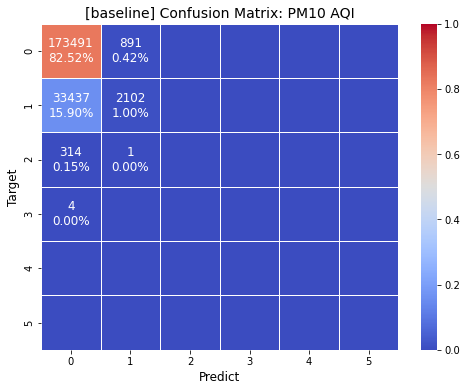

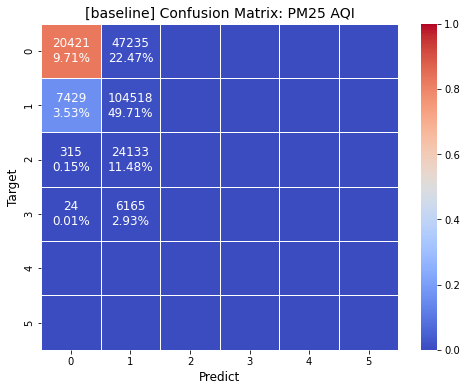

  0%|          | 0/35 [00:00<?, ?it/s]

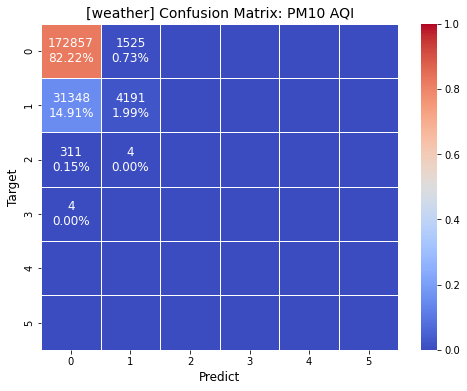

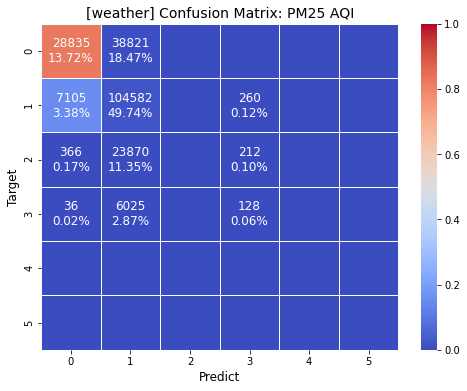

  0%|          | 0/35 [00:00<?, ?it/s]

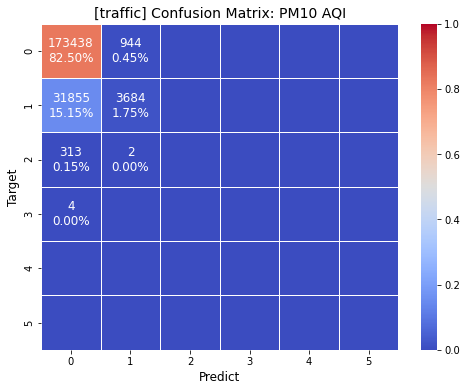

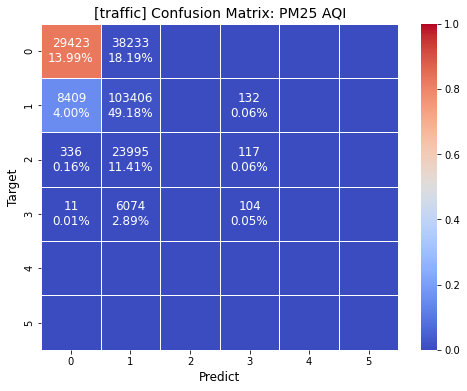

In [130]:
for exp_type in ["baseline", "weather", "traffic"]:
    eval_metrics_and_draw(exp_type=exp_type, model=model_dict[exp_type], m1=m1, m2=m2)

In [169]:
for x in baseline_model.val_dataloader():
    t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = x 
    t_seoul, t_seoul_dist, t_baek, t_beak_dist = map(lambda t: t[0].unsqueeze(0), [t_seoul, t_seoul_dist, t_baek, t_beak_dist])
    t_output = t_output.view(256, 24, 2)[0].unsqueeze(0)
    break

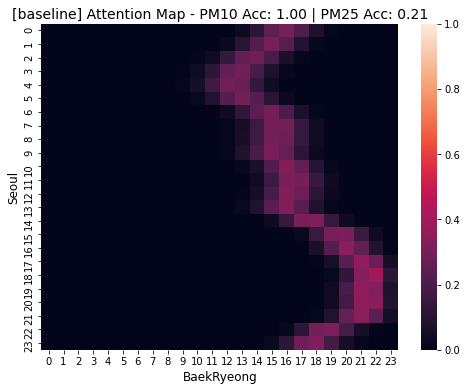

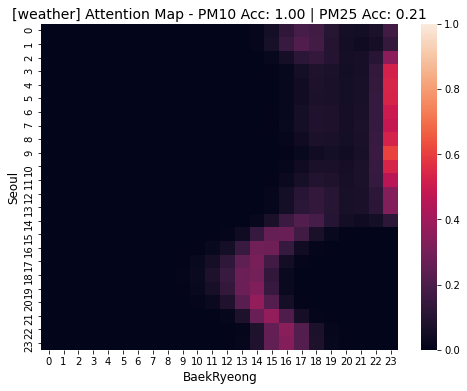

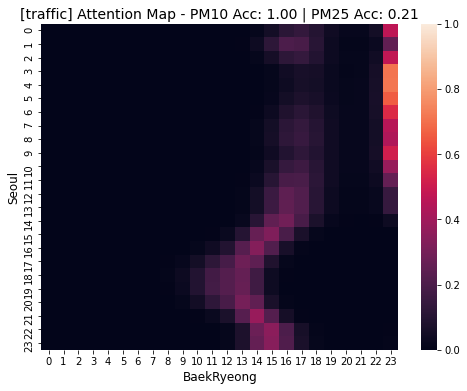

In [173]:
for exp_type in ["baseline", "weather", "traffic"]:
    model = model_dict[exp_type]
    model.eval()
    idx = 128
    for x in model.val_dataloader():
        t_seoul, t_seoul_dist, t_baek, t_beak_dist, t_output = x 
        t_seoul, t_seoul_dist, t_baek, t_beak_dist = map(lambda t: t[idx].unsqueeze(0), [t_seoul, t_seoul_dist, t_baek, t_beak_dist])
        t_output = t_output.view(256, 24, 2)[idx].unsqueeze(0)
        break
    
    o_pm10, o_pm25, attn = model(t_seoul, t_seoul_dist, t_baek, t_beak_dist, rt_attn=True)
    p_pm10, p_pm25, t_pm10, t_pm25 = model.cal_metrics(o_pm10, o_pm25, t_output)
    acc_pm10 = ((p_pm10 == t_pm10).sum() / len(t_pm10)).item()
    acc_pm25 = ((p_pm25 == t_pm25).sum() / len(t_pm25)).item()
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.heatmap(attn[0].detach().numpy(), vmax=1, vmin=0, ax=ax)
    ax.set_title(f"[{exp_type}] Attention Map - PM10 Acc: {acc_pm10:.2f} | PM25 Acc: {acc_pm25:.2f}", fontsize=14)
    ax.set_xlabel("BaekRyeong", fontsize=12)
    ax.set_ylabel("Seoul", fontsize=12)
    plt.show()

    fig.savefig(f"[{exp_type}] Attention Map.png")